<a href="https://colab.research.google.com/github/alicienty/ha/blob/main/%D0%9B%D1%83%D0%BA%D1%8C%D1%8F%D0%BD%D1%87%D0%B8%D0%BA%D0%BE%D0%B2%D0%B0_SMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```Курс "Компьютерная лингвистика" | НИУ ВШЭ Санкт-Петербург
2024 (c) В.И. Фирсанова```

# Tiny SMT

*Обзор*

**Введение (20 минут)**

1. **Компоненты SMT (15 минут)**
   - Определение SMT
   - Компоненты: параллельные корпуса, выравнивание, языковая модель, модель перевода, декодер

2. **Загрузка библиотек (5 минут)**
   - Библиотеки для обработки текстов: NLTK, Spacy
   - Библиотеки для машинного обучения: Scikit-learn

**Tiny SMT (60 минут)**

**1: Препроцессинг (15 минут)**

1. **Паралелльные корпуса (5 минут)**
   - Полезные ресурсы
   - Загрузка датасета EN-DE

2. **Подготовка данных (10 минут)**
   - Чистка данных
   - Токенизация

**2: Модель SMT (20 минут)**

1. **IBM 1 EM (10 минут)**
   - Алгоритм Expectation-Maximization
   - Пишем t-модель с нуля!

2. **LM (10 минут)**
   - Биграммная языковая модель
   - Пишем крошечную LM

**3: Оценка результатов (10 минут)**

1. **BLEU Score (5 минут)**
   - Как считать BLEU
   - Оцениваем нашу модель

2. **Интерпретация результатов (5 минут)**
   - Генерация примеров
   - Интерпретация!

**Домашнее задание:**

- Обучить модель на корпусе EN-RU

# Введение

## Компоненты SMT

**Формальное определение SMT (как это считать --> математика):**
- дано предложение на языке X,
- найти наиболее правдоподобный перевод этого предложения на язык Y:
  - найти такое предложение, которое максимизирует `P(y|x)`, т.е. `argmax P(y|x)`:
    - вычислить допустимые варианты предложений на языке Y путем создания языковой модели `P(y)`;
    - вычислить допустимые пары X - Y путем сопоставления статистических совпадений выравненных фраз в параллельном корпусе `P(x|y)`;
    - максимизировать результат вычисления `P(y) P(x|y)`, т.е. `argmax P(y) P(x|y)`

**Компоненты модели SMT (как это программировать --> код):**

1. ***N-граммная языковая модель*** - моделируем *вероятностное распределение* конструкций на уровне слов или фраз в языке Y
2. ***Модель перевода (t-model)*** - собираем *статистику* соотвествий фраз в паралелльном корпусе, ищем переводческие соответствия X - Y и моделируем их с помощью теории *вероятности*:
  1. Допускаем, что любое предложение языка Y может быть "искаженной" версией некой фразы на языке X
  2. Ищем наиболее правдоподобные соответствия X - Y
3. ***Декодер*** - ищем наиболее грамматичные и лексически правдоподобные результаты, отбираем среди *гипотез* один результат

## Загрузка библиотек

Ваши друзья:

[`sklearn`](https://scikit-learn.org/stable/)

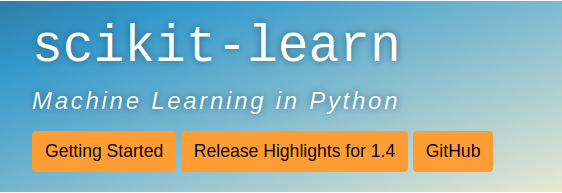

In [1]:
import tarfile

from sklearn.model_selection import train_test_split

from collections import Counter, defaultdict
import random

# *Tiny* SMT

## 1: Препроцессинг

### Параллельные корпуса

[OPUS](https://opus.nlpl.eu/) Corpora

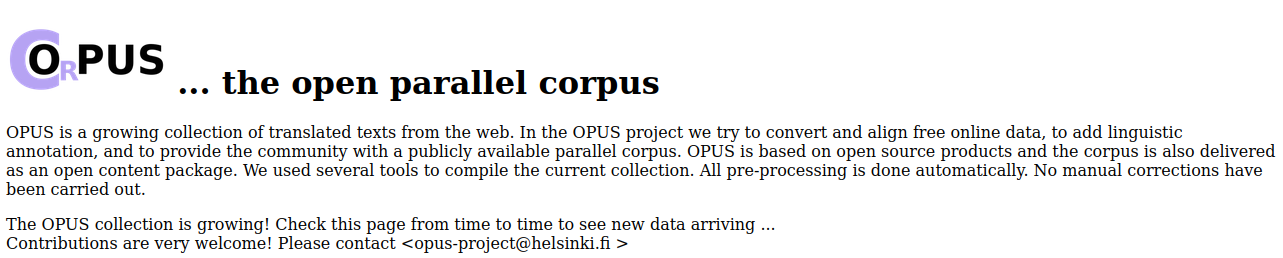

[Kaggle](https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench)

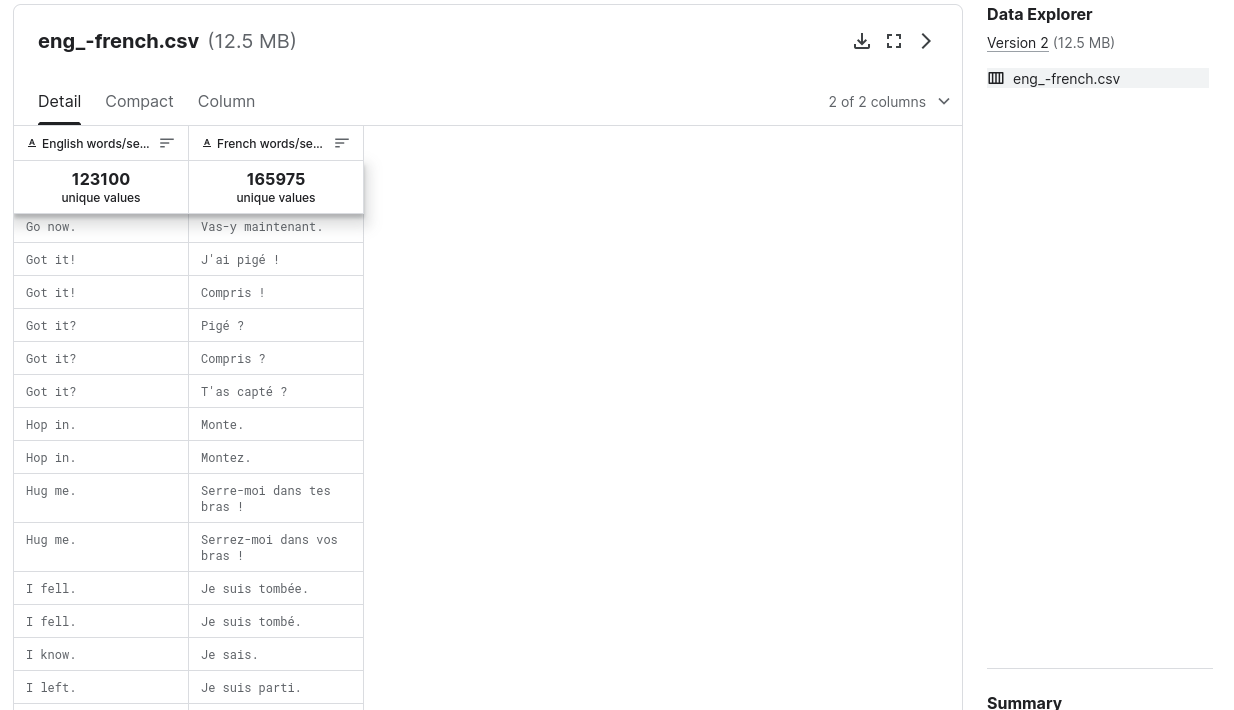

[HuggingFace](https://huggingface.co/datasets?task_categories=task_categories:translation&sort=trending)

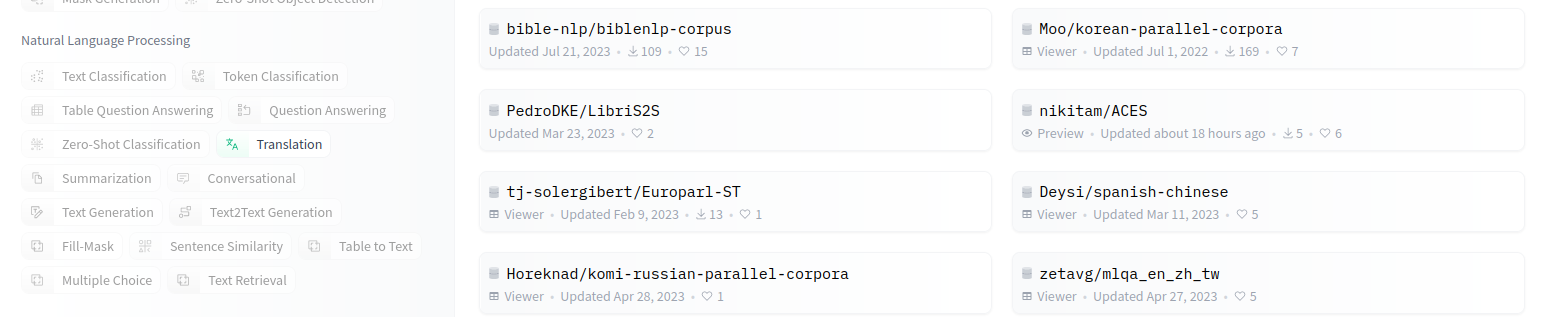

**Задание 1**

Загрузим датасет [Toy 6 short sentences](https://www.cis.lmu.de/~fraser/EMA2008/model1.html)

In [3]:
# извлекаем файлы из архива
with tarfile.open('/content/de-en.tgz', 'r:gz') as tar:
  tar.extractall()

Вызовем команду shell `ls`, чтобы увидеть, что мы распаковали.

In [4]:
!ls

de-en.de  de-en.en  de-en.tgz  sample_data


Создаем 2 выборки и токенизируем тексты по фразам.

In [5]:
with open('de-en.de', 'r') as f:
  german = f.read().split('\n')[:-1]

with open('de-en.en', 'r') as f:
  english = f.read().split('\n')[:-1]

print("Данные языка X:\n", german)
print("Данные языка Y:\n", english)

Данные языка X:
 ['Wiederaufnahme der Sitzungsperiode', 'Ich erkläre die am Freitag , dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen , wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe , daß Sie schöne Ferien hatten .', 'Wie Sie feststellen konnten , ist der gefürchtete " Millenium-Bug " nicht eingetreten . Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden .', 'Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen .', 'Heute möchte ich Sie bitten - das ist auch der Wunsch einiger Kolleginnen und Kollegen - , allen Opfern der Stürme , insbesondere in den verschiedenen Ländern der Europäischen Union , in einer Schweigeminute zu gedenken .', 'Ich bitte Sie , sich zu einer Schweigeminute zu erheben .', '( Das Parlament erhebt sich zu einer Schweigeminute . )', 'Frau Präsidentin , zur Geschäftsordnung .', 'Wie Sie sicher aus 

Разделим нашу выборку с помощью sklearn.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(english, german)

print("> Обучающая выборка:")
for text, label in zip(X_train, y_train):
    print(f"\nТекст на немецком: {label}\n Его перевод на английский: {text}\n")

print("> Тестовая выборка:")
for text, label in zip(X_test, y_test):
    print(f"\nТекст на немецком: {label}\n Его перевод на английский: {text}\n")

> Обучающая выборка:

Текст на немецком: Es bleibt zu hoffen , daß die Stellungnahmen des Parlaments bei der Halbzeitbewertung und für die praktische Umsetzung dennoch von Nutzen sind .
 Его перевод на английский: Hopefully , the stands Parliament has taken will help , however , in the mid-term appraisal of the programmes and in their practical implementation .


Текст на немецком: Das hat uns inspiriert , dasselbe auch für staatliche Beihilfen vorzuschlagen .
 Его перевод на английский: It was this which inspired us to propose the same thing with regard to state aid .


Текст на немецком: Ich meine , daß der Grundsatz der relativen Stabilität einen elementaren Rechtsgrundsatz der gemeinsamen Fischereipolitik darstellt und ein Vorschlag , diesen zu unterlaufen , rechtlich unzulässig wäre .
 Его перевод на английский: I believe that the principle of relative stability is a fundamental legal principle of the common fisheries policy and a proposal to subvert it would be legally inadmissib

### Подготовка данных

На этом этапе вы можете провести чистку данных, выделить би- или триграммы и т.д. Проведем пословную токенизацию каждой фразы.

In [7]:
def tokenize(sentences):
  # функция возвращает списки слов
  return [sentence.split() for sentence in sentences]

# токенизируем каждую выборку
X_train_tokens, X_test_tokens, y_train_tokens, y_test_tokens = tokenize(X_train), tokenize(X_test), tokenize(y_train), tokenize(y_test)

print('Образец токенизированного текста:', X_train_tokens)

Образец токенизированного текста: [['Hopefully', ',', 'the', 'stands', 'Parliament', 'has', 'taken', 'will', 'help', ',', 'however', ',', 'in', 'the', 'mid-term', 'appraisal', 'of', 'the', 'programmes', 'and', 'in', 'their', 'practical', 'implementation', '.'], ['It', 'was', 'this', 'which', 'inspired', 'us', 'to', 'propose', 'the', 'same', 'thing', 'with', 'regard', 'to', 'state', 'aid', '.'], ['I', 'believe', 'that', 'the', 'principle', 'of', 'relative', 'stability', 'is', 'a', 'fundamental', 'legal', 'principle', 'of', 'the', 'common', 'fisheries', 'policy', 'and', 'a', 'proposal', 'to', 'subvert', 'it', 'would', 'be', 'legally', 'inadmissible', '.'], ['We', 'see', 'it', 'as', 'a', 'very', 'positive', 'sign', 'that', ',', 'in', 'her', 'own', 'conclusions', ',', 'the', 'rapporteur', 'has', 'taken', 'account', 'of', 'our', 'committee', "'", 's', 'proposal', 'that', 'the', 'Cohesion', 'Fund', 'countries', 'should', 'broaden', 'the', 'research', 'infrastructure', 'by', 'locating', 'univ

Создадим словарь уникальных словоформ.

In [8]:
x_vocab = Counter(' '.join(german).split()).keys()
y_vocab = Counter(' '.join(english).split()).keys()

print(f"Словарь немецких словоформ: {x_vocab}\n Всего {len(x_vocab)} словоформ")
print(f"\nCловарь английских словоформ: {y_vocab}\n Всего {len(y_vocab)} словоформ")

Словарь немецких словоформ: dict_keys(['Wiederaufnahme', 'der', 'Sitzungsperiode', 'Ich', 'erkläre', 'die', 'am', 'Freitag', ',', 'dem', '17.', 'Dezember', 'unterbrochene', 'des', 'Europäischen', 'Parlaments', 'für', 'wiederaufgenommen', 'wünsche', 'Ihnen', 'nochmals', 'alles', 'Gute', 'zum', 'Jahreswechsel', 'und', 'hoffe', 'daß', 'Sie', 'schöne', 'Ferien', 'hatten', '.', 'Wie', 'feststellen', 'konnten', 'ist', 'gefürchtete', '"', 'Millenium-Bug', 'nicht', 'eingetreten', 'Doch', 'sind', 'Bürger', 'einiger', 'unserer', 'Mitgliedstaaten', 'Opfer', 'von', 'schrecklichen', 'Naturkatastrophen', 'geworden', 'Im', 'Parlament', 'besteht', 'Wunsch', 'nach', 'einer', 'Aussprache', 'im', 'Verlauf', 'dieser', 'in', 'den', 'nächsten', 'Tagen', 'Heute', 'möchte', 'ich', 'bitten', '-', 'das', 'auch', 'Kolleginnen', 'Kollegen', 'allen', 'Opfern', 'Stürme', 'insbesondere', 'verschiedenen', 'Ländern', 'Union', 'Schweigeminute', 'zu', 'gedenken', 'bitte', 'sich', 'erheben', '(', 'Das', 'erhebt', ')', 'F

## 2: Модель SMT

### IBM 1 Expectation-Maximization (t-model)

In [27]:
# вероятность того, что случайное слово x_vocab соответсвует случайному слову y_vocab
uniform = 1 / (len(x_vocab) * len(y_vocab))

round(uniform, 7)

1e-07

In [29]:
# t-model
t = {}

for i in range(len(X_train)):
  # начинаем итерацию по обучающей выборке
  for word_x in X_train_tokens[i]:
    for word_y in y_train_tokens[i]:
      # создаем t-table
      t[(word_x, word_y)] = uniform

# t-table
for elem in t:
  print("Соответствие |", elem[0], "  ->  ", elem[1], "| Вероятность:", round(t[elem], 7))

Выходные данные были обрезаны до нескольких последних строк (5000).
Соответствие | economies   ->   aus | Вероятность: 1e-07
Соответствие | the   ->   empörende | Вероятность: 1e-07
Соответствие | the   ->   Machtkonzentration | Вероятность: 1e-07
Соответствие | the   ->   strategisch | Вероятность: 1e-07
Соответствие | the   ->   liefert | Вероятность: 1e-07
Соответствие | the   ->   ganzer | Вероятность: 1e-07
Соответствие | the   ->   Profit | Вероятность: 1e-07
Соответствие | the   ->   multinationalen | Вероятность: 1e-07
Соответствие | the   ->   Konzernen | Вероятность: 1e-07
Соответствие | size   ->   Die | Вероятность: 1e-07
Соответствие | size   ->   empörende | Вероятность: 1e-07
Соответствие | size   ->   Machtkonzentration | Вероятность: 1e-07
Соответствие | size   ->   strategisch | Вероятность: 1e-07
Соответствие | size   ->   wichtigen | Вероятность: 1e-07
Соответствие | size   ->   Sektoren | Вероятность: 1e-07
Соответствие | size   ->   liefert | Вероятность: 1e-07
Со

In [30]:
# количество итераций обучения
epochs = 7

In [31]:
for epoch in range(epochs):
  # начинаем обучение

  # шаг 0. создаем слоты для подсчета статистики
  count = {} # P(x|y)
  total = {} # P(y)

  for i in range(len(X_train)):
    # начинаем итерацию по обучающей выборке
    for word_x in X_train_tokens[i]:
      for word_y in y_train_tokens[i]:
        # создаем слоты для подсчета условной вероятности совпадений в корпусе
        count[(word_x, word_y)] = 0
        # и слоты для статистической языковой модели y
        total[word_y] = 0

  # шаг 1. Expectation
  for i in range(len(X_train)):
    # начинаем итерацию по обучающей выборке
    total_stat = {} # статистика x

    # собираем предварительную статистику на основе данных x
    for word_x in X_train_tokens[i]:
      total_stat[word_x] = 0 # создаем слоты для подсчета статистики по каждому токену x
      for word_y in y_train_tokens[i]:
        # обновляем данные из t-table; увеличиваем значения при обнаружении совместной встречаемости
        total_stat[word_x] += t[(word_x, word_y)]

    # обновляем данные для P(x|y) и P(y)
    for word_x in X_train_tokens[i]:
      for word_y in y_train_tokens[i]:
        # подсчет условной вероятности совпадений в корпусе: равномерное распределение / частотность x
        count[(word_x, word_y)] += t[(word_x, word_y)] / total_stat[word_x]
        # подсчет статистической информации y: равномерное распределение / частотность x
        total[word_y] += t[(word_x, word_y)] / total_stat[word_x]

  # шаг 2. Maximization
  for i in range(len(X_train)):
    # начинаем итерацию по обучающей выборке
    for word_x in X_train_tokens[i]:
      for word_y in y_train_tokens[i]:
        # обновляем t-table: вероятность совпадения в корпусе / вероятность информации y
        t[(word_x, word_y)] = count[(word_x, word_y)] / total[word_y]

for elem in t:
  print("Соответствие |", elem[0], "  ->  ", elem[1], "| Вероятность:", round(t[elem], 7))

Выходные данные были обрезаны до нескольких последних строк (5000).
Соответствие | economies   ->   aus | Вероятность: 0.0
Соответствие | the   ->   empörende | Вероятность: 7.31e-05
Соответствие | the   ->   Machtkonzentration | Вероятность: 7.31e-05
Соответствие | the   ->   strategisch | Вероятность: 7.31e-05
Соответствие | the   ->   liefert | Вероятность: 2.5e-06
Соответствие | the   ->   ganzer | Вероятность: 7.31e-05
Соответствие | the   ->   Profit | Вероятность: 7.31e-05
Соответствие | the   ->   multinationalen | Вероятность: 7.31e-05
Соответствие | the   ->   Konzernen | Вероятность: 7.31e-05
Соответствие | size   ->   Die | Вероятность: 0.0
Соответствие | size   ->   empörende | Вероятность: 0.0672677
Соответствие | size   ->   Machtkonzentration | Вероятность: 0.0672677
Соответствие | size   ->   strategisch | Вероятность: 0.0672677
Соответствие | size   ->   wichtigen | Вероятность: 0.0001794
Соответствие | size   ->   Sektoren | Вероятность: 0.0011137
Соответствие | size

### Биграммная модель

In [32]:
# для обучения модели объединим 2 выборки
tokens = ' '.join(german).split()

# хранилище для биграмм
bigram_model = defaultdict(list)

# собираем все попарные совпадения
for i in range(len(tokens)-1):
    current_word = tokens[i]
    next_word = tokens[i + 1]
    bigram_model[current_word].append(next_word)

print(bigram_model)

def decoder(model, steps=5):
  # инициализация случайного токена
  current_word = random.choice(tokens)
  generated_sentence = current_word

  for step in range(steps):
    # пошаговая генерация
    print('Шаг', step+1)
    next_word_options = model[current_word]
    print(f'Правдоподобные варианты продолжения для токена {current_word}:', next_word_options)

    current_word = random.choice(next_word_options)
    generated_sentence += ' '
    generated_sentence += current_word
    print('Промежуточный результат:', generated_sentence)
    print()
  print('Результат:', generated_sentence)

decoder(bigram_model)

defaultdict(<class 'list'>, {'Wiederaufnahme': ['der', 'der'], 'der': ['Sitzungsperiode', 'gefürchtete', 'Wunsch', 'Wunsch', 'Stürme', 'Europäischen', 'Presse', 'dem', 'Präsidentin', 'Unzulässigkeit', 'in', 'relativen', 'Grundsatz', 'relativen', 'gemeinsamen', 'Aussprache', 'vom', 'gesamten', 'Institution', 'zur', 'Vollstreckung', 'Position', 'Fall', 'Zugang', 'Staatsanwalt', 'letzten', 'Barentsee', 'Ihnen', 'Beschlüsse', 'ersten', 'Tagesordnung', 'Quästoren', 'Arbeitsschutzausschuß', 'Vizepräsidentin', 'Meinung', 'Fall', 'Tageszeitung', 'heutigen', 'eine', 'Vergangenheit', 'dortigen', 'großen', 'EU-Mitgliedstaaten', 'EU', 'Tagesordnung', 'Tagesordnung', 'Geschäftsordnung', 'Konferenz', 'Präsidenten', 'Kommission', 'Kommission', 'Kommission', 'Fraktion', 'Sozialdemokratischen', 'die', 'Konferenz', 'Präsidenten', 'seine', 'vorangegangenen', 'empfohlen', 'kürzestmöglichen', 'vergangenen', 'Konferenz', 'Präsidenten', 'Lage', 'Lage', 'Abstimmung', 'Kommission', 'Lage', 'Meinung', 'Lage', '

## 3: Оценка результатов

[NLTK Translate](https://www.nltk.org/api/nltk.translate.bleu_score.html)

In [35]:
# сортировка t-table по убыванию правдоподобия

sorted_t = sorted(t.items(), key = lambda k:(k[1], k[0]), reverse = True)

def translate(token):
  for element in sorted_t:
    if element[0][1] == token:
      # поиск совпадений в t-table
      return element[0][0]
  return ''  # Возвращаем пустую строку, если перевод не найден

for sentence in y_test_tokens:
  print("Оригинальное предложение:", ' '.join(sentence))
  translation = []
  for token in sentence:
    translation.append(translate(token))
  print("Перевод:", ' '.join(translation))

Оригинальное предложение: Das bedeutet nicht , daß ich nicht die Notwendigkeit von Wettbewerbsstärke sehe , um so mehr , als ich selbst Unternehmer in einem Ziel 1-Gebiet bin , und zwar in Brandenburg in der Bundesrepublik Deutschland , und sehr wohl die Sorgen und Nöte von klein- und mittelständischen Unternehmen kenne .
Перевод: . less not , that I not the need the  time , to the more , as I and part in a is  I , and we in  in the  totalling , and very still the  and  the  and  to  .
Оригинальное предложение: Wie steht der Rat dazu , und ist der Herr Kommissar bereit , diese Punkte noch einmal gründlich zu überdenken ?
Перевод: a is the Council to , and is the Mr Commissioner what , the points , again ensuring to reconsider ?
Оригинальное предложение: Mein Teil in der heutigen Debatte betrifft den Stahlbeihilfekodex . Das sind die öffentlichen Hilfen in Europa , die nach diesem Kodex vergeben wurden und die die Kommission geprüft hat .
Перевод:  in in the  debate which the code . . ,

In [40]:
from nltk.translate.bleu_score import corpus_bleu

reference = [X_test_tokens[0]]  # Или любое другое предложение

candidate = [translate(token) for token in y_test_tokens[0]]

bleu_score = corpus_bleu([reference], [candidate])

print("BLEU Score:", bleu_score)

BLEU Score: 6.5573712515666825e-155


In [41]:
reference

[['This',
  'does',
  'not',
  'mean',
  'that',
  'I',
  'do',
  'not',
  'see',
  'the',
  'need',
  'for',
  'competitiveness',
  ',',
  'particularly',
  'as',
  'I',
  'myself',
  'am',
  'an',
  'entrepreneur',
  'in',
  'an',
  'Objective',
  '1',
  'Region',
  ',',
  'that',
  'is',
  'in',
  'Brandenburg',
  'in',
  'the',
  'Federal',
  'Republic',
  'of',
  'Germany',
  ',',
  'and',
  'am',
  'only',
  'too',
  'aware',
  'of',
  'the',
  'problems',
  'and',
  'concerns',
  'of',
  'small',
  'and',
  'medium-sized',
  'enterprises',
  '.']]

In [42]:
candidate

['.',
 'less',
 'not',
 ',',
 'that',
 'I',
 'not',
 'the',
 'need',
 'the',
 '',
 'time',
 ',',
 'to',
 'the',
 'more',
 ',',
 'as',
 'I',
 'and',
 'part',
 'in',
 'a',
 'is',
 '',
 'I',
 ',',
 'and',
 'we',
 'in',
 '',
 'in',
 'the',
 '',
 'totalling',
 ',',
 'and',
 'very',
 'still',
 'the',
 '',
 'and',
 '',
 'the',
 '',
 'and',
 '',
 'to',
 '',
 '.']

Что почитать? Учебник "Statistical Machine Translation", Philipp Koehn

Домашнее задание:

1. Повторить проведенный эксперимент на любом другом корпусе на выбор из туториала https://www.cis.lmu.de/~fraser/EMA2008/model1.html (по желанию)
2. Своими словами описать принцип работы SMT (основные компоненты, важную терминологию) - сделайте это в формате конспекта-шпаргалки, к которой вы сможете вернуться в будущем (обязательно)

# Принцип работы SMT (конспект-шпаргалка)

**Статистический машинный перевод (SMT)** — это метод автоматического перевода, который основан на статистических моделях, анализирующих двуязычные корпуса текста. Основная задача SMT заключается в нахождении наиболее вероятного перевода предложения с языка X на язык Y, что формально можно записать как:

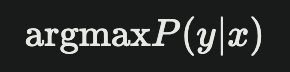

где P(y∣x) — это вероятность перевода y при условии x.

Простыми словами: SMT переводит текст с использованием статистических моделей. Эти модели обучены на большом параллельном корпусе. Система учится на конкретных примерах перевода, а не работает по заранее установленным правилам.

**Основные этапы работы SMT:**

1. Сбор параллельных корпусов. Эти данные служат основой для обучения моделей перевода.
2. Создание языковой модели. Вычисляется допустимое распределение предложений на языке Y с помощью языковой модели P(y), которая основана на частотах слов и фраз.
3. Сопоставление фраз: Вычисляются вероятности соответствий фраз между языками X и Y через анализ параллельного корпуса, что дает P(x∣y).
4. Максимизация произведения P(y)⋅P(x∣y) --> позволяет находить наиболее вероятные переводы.

**Основные компоненты:**
1. **Параллельные корпуса** – большой объем текстов на двух языках.
2. **Выравнивание** – процесс сопоставления слов или фраз между языками в параллельном корпусе, который позволяет определить, какие элементы одного языка соответствуют элементам другого.
3. **N-граммная языковая модель** – моделирует вероятностное распределение слов и фраз в языке Y. Вероятность следующего слова зависит только от предыдущих слов.
4. **Модель перевода** (t-model) – собирает статистику соответствий фраз в параллельном корпусе, предполагая, что любое предложение на языке Y может быть искаженной версией фразы на языке X. Это позволяет искать наиболее правдоподобные соответствия между языками.
5. **Декодер** – отвечает за выбор наиболее грамматичных и лексически правдоподобных результатов из множества гипотез перевода.

**Библиотеки, которые могут понадобиться в этой задаче:**

Scikit-learn – библиотека для машинного обучения

nltk – библиотека для обработки текста

pandas – библиотека для работы с табличными данными (вдруг надо что-то в параллельном корпусе почистить)


Важная терминология:

* n-грамма – последовательность из n слов

* Translation Probability – вероятность того, что фраза на целевом языке является переводом фразы на исходном языке, по TM.

* Language Model Probability – вероятность того, что фраза грамматически правильна и осмысленна на целевом языке, по LM.

* Alignment – соответствие слов или фраз в исходном и целевом текстах в параллельном корпусе.

* Decoding – процесс поиска лучшего перевода.

* Алгоритм Expectation-Maximization (EM) — это метод, который помогает находить лучшие оценки параметров статистических моделей.

  Основные шаги алгоритма:

  * E-шаг (Ожидание): На этом этапе мы предполагаем значения скрытых данных и вычисляем, как они влияют на текущие параметры модели.

  * M-шаг (Максимизация): Здесь мы обновляем параметры модели, чтобы максимизировать вероятность наблюдаемых данных с учетом значений, найденных на E-шаге.
* Биграммная языковая модель — это тип статистической языковой модели, которая использует последовательности из двух слов (биграммы) для предсказания вероятности появления следующего слова в тексте.

* BLEU (Bilingual Evaluation Understudy) — это метрика, используемая для оценки качества машинного перевода. Она сравнивает сгенерированный машиной текст с одним или несколькими эталонными переводами, выполненными человеком, и измеряет, насколько они похожи.
